In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(device)

cuda:0


# Initialize for CPU & GPU

In [2]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal


Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.3.1-py3-none-any.whl


# Import

In [3]:
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import NNConv
from torch import autograd

from sklearn.model_selection import train_test_split

# DataLoader

In [4]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]
Additional_Attr = List[np.ndarray]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
    ):
        
        self.edge_flag = torch.LongTensor(edge_flag)
        self.edge_index = torch.LongTensor(edge_index).T.to(device)
        self.edge_attr = edge_attr
        self.node_flag = torch.LongTensor(node_flag)
        self.node_index = torch.LongTensor(node_index).to(device)
        self.node_attr = node_attr
        self.ts_list = ts_list
        self.edge_attr_encoded = None
        self.node_attr_encoded = None
        
        self._set_snapshot_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.edge_flag)
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.edge_attr)).to(device)
    
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.node_attr)).to(device)
        
    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    # def _get_edge_weight(self, time_index: int):
    #     if self.edge_weights[time_index] is None:
    #         return self.edge_weights[time_index]
    #     else:
    #         return torch.FloatTensor(self.edge_weights[time_index])

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp = _timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp']
        )
        return dataset

# Model

## MultiNNConv

In [5]:
class MultiNNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_channels, gcn_layers, edge_layers, lin_layers):
        super().__init__()
        
        def _create_edge_net(edge_out_channels):
            edge_nn = Seq()
            pre_size = edge_channels
            for size in edge_layers:
                edge_nn.append(Lin(pre_size,size))
                edge_nn.append(ReLU())
                pre_size = size
            edge_nn.append(Lin(pre_size,edge_out_channels))
            return edge_nn
        
        self.gcn_layers = nn.ModuleList()
        pre_size = in_channels
        for size in gcn_layers:
            edge_net = _create_edge_net(pre_size*size)
            self.gcn_layers.append(NNConv(pre_size, size, edge_net, aggr='mean'))
            pre_size = size
        
        self.lin_net = Seq()
        for size in lin_layers[:-1]:
            self.lin_net.append(Lin(pre_size,size))
            pre_size = size
        self.lin_net.append(ReLU())
        self.lin_net.append(Lin(pre_size,out_channels))

    def forward(self, x, edge_index, edge_attr):
        out = x
        for conv in self.gcn_layers:
            out = conv(
                x=out,
                edge_index=edge_index,
                edge_attr=edge_attr,
            )
        out = self.lin_net(out)
        return out

# Graph GRU Unit

In [6]:
class NNConvGRU(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_channels: int,
        gcn_layers: List,
        edge_layers: List,
        lin_layers: List,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_channels = edge_channels
        self.gcn_layers = gcn_layers
        self.edge_layers = edge_layers
        self.lin_layers = lin_layers
            
        self.normalization = normalization
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiNNConv(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_layers = self.gcn_layers,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

        self.conv_h_z = MultiNNConv(
            in_channels = self.out_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_layers = self.gcn_layers,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiNNConv(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_layers = self.gcn_layers,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

        self.conv_h_r = MultiNNConv(
            in_channels = self.out_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_layers = self.gcn_layers,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiNNConv(
            in_channels = self.in_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_layers = self.gcn_layers,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

        self.conv_h_h = MultiNNConv(
            in_channels = self.out_channels,
            out_channels = self.out_channels,
            edge_channels = self.edge_channels,
            gcn_layers = self.gcn_layers,
            edge_layers = self.edge_layers,
            lin_layers = self.lin_layers,
        )

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_attr, H):
        Z = self.conv_x_z(X, edge_index, edge_attr)
        Z = Z + self.conv_h_z(H, edge_index, edge_attr)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_attr, H):
        R = self.conv_x_r(X, edge_index, edge_attr)
        R = R + self.conv_h_r(H, edge_index, edge_attr)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_attr, H, R):
        H_tilde = self.conv_x_h(X, edge_index, edge_attr)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index, edge_attr)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            edge_attr: torch.FloatTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
            H = self._set_hidden_state(X, H)
            Z = self._calculate_update_gate(X, edge_index, edge_attr, H)
            R = self._calculate_reset_gate(X, edge_index, edge_attr, H)
            H_tilde = self._calculate_candidate_state(X, edge_index, edge_attr, H, R)
            H = self._calculate_hidden_state(Z, H, H_tilde)
            return H

# Graph GRU Layer and Global Hidden Function

In [7]:
def create_hidden(num_node, out_channels):
#     hidden_global = torch.FloatTensor(np.zeros([num_node,out_channels])).to(device)
    hidden =torch.zeros([num_node,out_channels], dtype=torch.float).to(device)
    return hidden

def select_hidden(hidden, index):
#     h = hidden_global[index] #REGULAR INDEXING
    h = hidden.index_select(dim=0, index=index) #INDEX SELECT
    return h

# TODO: Aggregation of hidden and cell
def update_hidden(hidden, h, index):
    # hidden_global[index] = h.detach() #REGULAR INDEXING
    # for key,value in mapping.items():
    #     hidden_global[value] = h[key] 
    hidden.index_copy_(dim=0, index=index, source=h.detach())        

class NNConvGRULayer(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_channels: int,
        gcn_layers: List,
        edge_layers: List,
        lin_layers: List,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super().__init__()
        self.gru = NNConvGRU(
            in_channels = in_channels,
            out_channels = out_channels,
            edge_channels = edge_channels,
            gcn_layers = gcn_layers,
            edge_layers = edge_layers,
            lin_layers = lin_layers,
            normalization = normalization,
            bias = bias
        )
        
        self.out_channels = out_channels
        
    def forward(
        self,
        X: torch.FloatTensor,
        node_index: torch.LongTensor,
        node_flag: torch.LongTensor,
        edge_index: torch.LongTensor,
        edge_attr: torch.FloatTensor,
        edge_flag: torch.LongTensor,
        num_node: int
    ) -> torch.FloatTensor:
        
        X_split = torch.tensor_split(X, node_flag)
        node_index_split = torch.tensor_split(node_index, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)
        
        hidden = create_hidden(num_node, self.out_channels)
        
        outs = []
        for _X,_node_index,_edge_index,_edge_attr in zip(X_split,node_index_split,edge_index_split,edge_attr_split):
            _hidden = select_hidden(hidden, _node_index)
            _new_hidden = self.gru(_X, _edge_index, _edge_attr, _hidden)
            update_hidden(hidden, _new_hidden, _node_index)
            outs.append(_new_hidden)
        
        H = torch.cat(outs)
        return H

## TGAE

In [8]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, in_channels, out_channels, edge_channels, 
        embedding_hidden_nums, gnn_out_channels, deciding_hidden_nums,
        gru_gcn_hidden_nums, gru_edge_hidden_nums, gru_lin_hidden_nums):
        super(TGAE, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_channels = edge_channels
        self.embedding_hidden_nums = embedding_hidden_nums
        self.gnn_out_channels = gnn_out_channels
        self.deciding_hidden_nums = deciding_hidden_nums
        self.gru_gcn_hidden_nums = gru_gcn_hidden_nums
        self.gru_edge_hidden_nums = gru_edge_hidden_nums
        self.gru_lin_hidden_nums = gru_lin_hidden_nums
        
        # Encoder
        layers = []
        pre_h_num = in_channels
        for h_num in embedding_hidden_nums[:-1]:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embedding_hidden_nums[-1]))
        self.encoder_embedding_net = Seq(*layers)
        
        self.encoder_gru = NNConvGRULayer(
            in_channels=embedding_hidden_nums[-1],
            out_channels=gnn_out_channels,
            edge_channels=edge_channels,
            gcn_layers=gru_gcn_hidden_nums,
            edge_layers=gru_edge_hidden_nums,
            lin_layers=gru_lin_hidden_nums,
        )

        layers = []
        pre_h_num = gnn_out_channels
        for h_num in deciding_hidden_nums:
#             layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
        self.encoder_deciding_net = Seq(*layers)
        
        # Decoder
        layers = []
        pre_h_num = out_channels
        for h_num in deciding_hidden_nums[::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,gnn_out_channels))
        self.decoder_deciding_net = Seq(*layers)
        
        self.decoder_gru = NNConvGRULayer(
            in_channels=gnn_out_channels,
            out_channels=embedding_hidden_nums[-1],
            edge_channels=edge_channels,
            gcn_layers=gru_gcn_hidden_nums,
            edge_layers=gru_edge_hidden_nums,
            lin_layers=gru_lin_hidden_nums,
        )
        
        layers = []
        pre_h_num = embedding_hidden_nums[-1]
        for h_num in embedding_hidden_nums[:-1][::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,in_channels))
        self.decoder_embedding_net = Seq(*layers)
        

    def forward(self, x, node_index, node_flag, edge_index, edge_attr, edge_flag, num_node):
        # Encoder
        out = self.encoder_embedding_net(x)
        
        # GNN layer
        h_encoder = self.encoder_gru(out, node_index, node_flag, edge_index, edge_attr, edge_flag, num_node) 
        
        out = self.encoder_deciding_net(h_encoder)
        
        out = self.decoder_deciding_net(out)
        
        # TODO Reverse Edge Index 
        
        h_decoder = self.decoder_gru(out, node_index, node_flag, torch.flip(edge_index,dims=(0,)), edge_attr, edge_flag, num_node)
        
        out = self.decoder_embedding_net(h_decoder)

        return out
    

# Training

## Read Data

In [9]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
y = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        raise

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    y.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, y_train, y_test = train_test_split(signals, y, test_size=0.2, random_state=1)
signals_train, signals_val, y_train, y_val = train_test_split(signals_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [10]:
node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.edge_attr for sample in signals_train]))

for signal in signals_train:
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)

X_train = []
for signal in signals_train:
#     X_train.append(list(signal))
    X_train.append(signal.node_attr_encoded.index_select(dim=0,index=signal.node_index))
    
num_node_train = []
for signal in signals_train:
    num_node_train.append(signal.node_attr.shape[0])

    
for signal in signals_val:
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)

X_val = []
# for signal in signals_val:
#     X_val.append(list(signal))
for signal in signals_val:
#     X_train.append(list(signal))
    X_val.append(signal.node_attr_encoded.index_select(dim=0,index=signal.node_index))

nums_node_val = []
for signal in signals_val:
    nums_node_val.append(signal.node_attr.shape[0])

In [11]:
# for sample in X_train[:1]:
#     for snapshot in sample:
#         node_attr = snapshot.node_attr
#         node_index = snapshot.node_index
#         edge_attr = snapshot.edge_attr
#         edge_index = snapshot.edge_index
        
#         print(f"node_attr: {node_attr.shape}")
#         print(f"node_index: {node_index.shape}")
#         print(f"edge_attr: {edge_attr.shape}")
#         print(f"edge_index: {edge_index.shape}")

In [12]:
IN_CHANNELS = signals_train[0].node_attr_encoded.shape[1]
EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

In [13]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=5, 
    edge_channels=EDGE_CHANNELS, 
    embedding_hidden_nums=[16,32],
    gnn_out_channels=8,
    deciding_hidden_nums=[16,16],
    gru_gcn_hidden_nums=[16,16],
    gru_edge_hidden_nums=[32],
    gru_lin_hidden_nums=[32,16],
)

loss_f = torch.nn.MSELoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4, weight_decay=1e-5)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (encoder_embedding_net): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (encoder_gru): NNConvGRULayer(
    (gru): NNConvGRU(
      (conv_x_z): MultiNNConv(
        (gcn_layers): ModuleList(
          (0): NNConv(32, 16, aggr=mean, nn=Sequential(
            (0): Linear(in_features=58, out_features=32, bias=True)
            (1): ReLU()
            (2): Linear(in_features=32, out_features=512, bias=True)
          ))
          (1): NNConv(16, 16, aggr=mean, nn=Sequential(
            (0): Linear(in_features=58, out_features=32, bias=True)
            (1): ReLU()
            (2): Linear(in_features=32, out_features=256, bias=True)
          ))
        )
        (lin_net): Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=8, bias=True)
        )
      )


## Train Loop

In [43]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device):
    model.train()
    
    X = signal.node_attr_encoded.index_select(dim=0,index=signal.node_index)
    node_index = signal.node_index
    node_flag = signal.node_flag
    edge_index = signal.edge_index
    edge_attr = signal.edge_attr_encoded
    edge_flag = signal.edge_flag
    
    outs = model(X, node_index, node_flag, edge_index, edge_attr, edge_flag, signal.node_attr.shape[0])

    train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
    total_loss = torch.sum(train_losses)
    snapshot_losses = train_losses.detach().index_select(dim=0,index=signal.node_index).cpu().numpy()
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return snapshot_losses

## Test Loop

In [70]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device):
    with torch.no_grad():
        X = signal.node_attr_encoded.index_select(dim=0,index=signal.node_index)
        node_index = signal.node_index
        node_flag = signal.node_flag
        edge_index = signal.edge_index
        edge_attr = signal.edge_attr_encoded
        edge_flag = signal.edge_flag

        outs = model(X, node_index, node_flag, edge_index, edge_attr, edge_flag, signal.node_attr.shape[0])

        train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
        total_loss = torch.sum(train_losses)
        snapshot_losses = [torch.sum(loss).cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
    return snapshot_losses

In [45]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    history_train = []
    history_val = []

    for i_epoch in range(1,num_epoch+1):
        train_losses = []
        _start = time.time()
        for signal in signals_train:
            snapshot_losses = train_loop(signal, model, loss_f, optimizer, device)
#             print(np.mean(train_loss))
            train_losses.append(np.mean(snapshot_losses))
            
        
        if i_epoch % 5 == 0:
            val_losses = []
            for signal in signals_val:
                snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
#                 print(np.mean(val_loss))
                val_losses.append(np.mean(snapshot_losses))
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train RMSE {np.mean(train_losses):.4f} val RMSE{np.mean(val_losses):.4f}")
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train RMSE {np.mean(train_losses):.4f}")
    return (history_train,history_val)

In [46]:
history_train_list = []
history_val_list = []

1/100: cost 35.6358s train RMSE 0.6973
2/100: cost 35.7718s train RMSE 0.6551
3/100: cost 35.7896s train RMSE 0.6234
5/100: cost 41.2746s train RMSE 0.5604 val RMSE0.5481
6/100: cost 36.4132s train RMSE 0.5306
7/100: cost 36.0201s train RMSE 0.5056
8/100: cost 35.6284s train RMSE 0.4856
9/100: cost 35.8333s train RMSE 0.4709
10/100: cost 41.7732s train RMSE 0.4605 val RMSE0.4637
11/100: cost 35.5663s train RMSE 0.4486
12/100: cost 36.1436s train RMSE 0.4364
13/100: cost 35.5756s train RMSE 0.4223
14/100: cost 35.6477s train RMSE 0.4093
15/100: cost 40.7807s train RMSE 0.3949 val RMSE0.3880
16/100: cost 36.0128s train RMSE 0.3745
17/100: cost 35.6030s train RMSE 0.3575
18/100: cost 36.2229s train RMSE 0.3427
19/100: cost 35.7197s train RMSE 0.3259
20/100: cost 41.0376s train RMSE 0.3125 val RMSE0.3021
21/100: cost 35.6441s train RMSE 0.2892
22/100: cost 36.0380s train RMSE 0.2708
23/100: cost 36.4353s train RMSE 0.2585
24/100: cost 37.0293s train RMSE 0.2450
25/100: cost 41.7102s train 

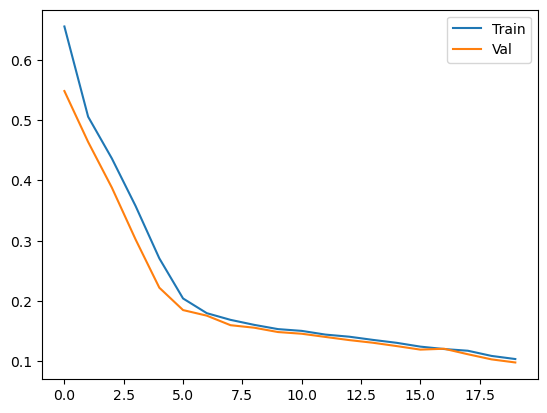

In [47]:
history_train, history_val = train_function(100)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

In [68]:
a = [1,2,3,4]
a[:-1]

[1, 2, 3]

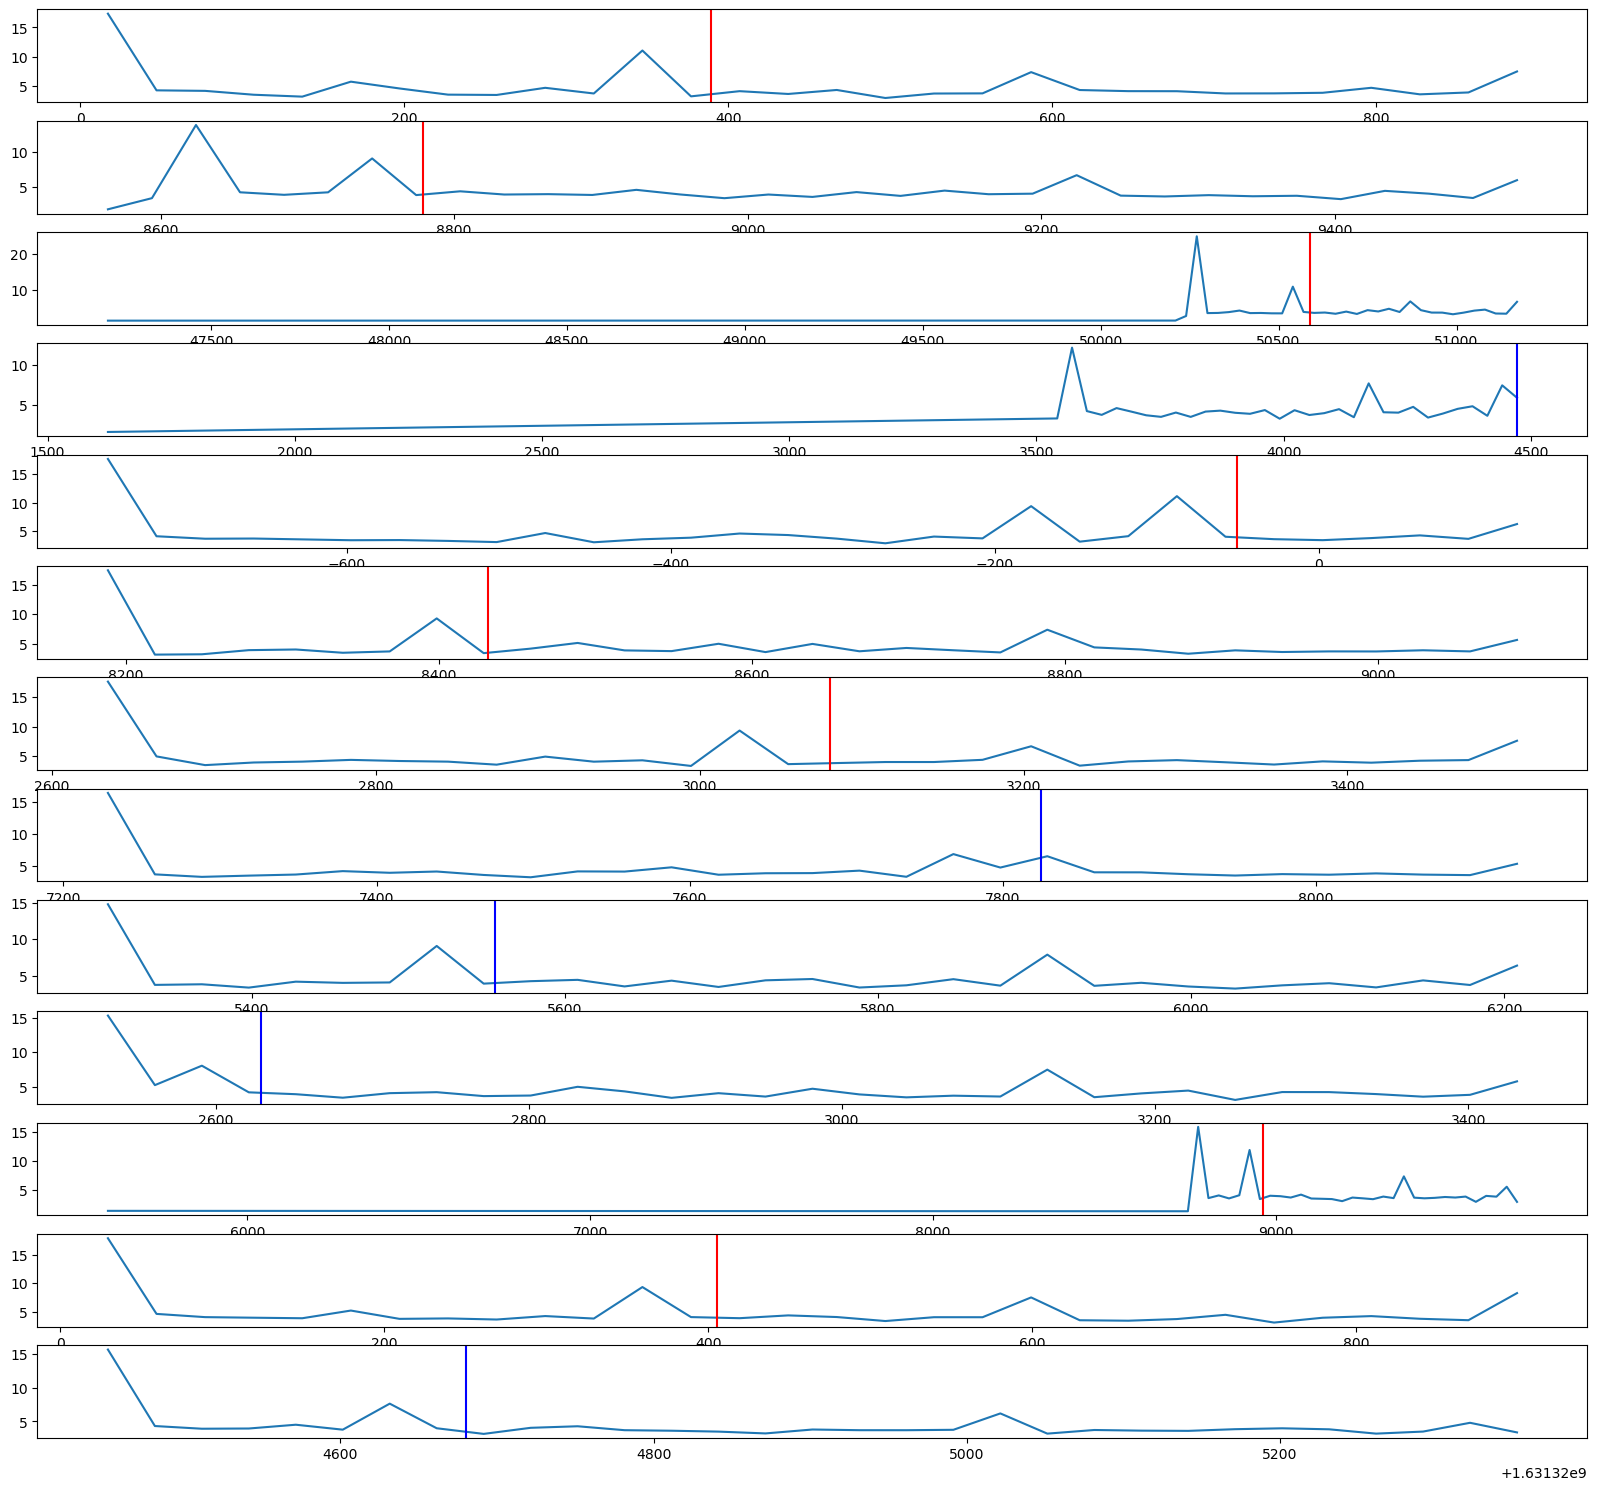

In [73]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
#                 print(np.mean(val_loss))
#     val_losses.append(np.mean(snapshot_losses))
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,snapshot_losses[:-1])
    if y[0] == 'dos':
        plt.axvline(x = float(y[1]), color = 'red', label = y[0])
    if y[0] == 'privesc':
        plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()
plt.savefig('val_res.png')

In [74]:
torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [ ]:
history_train, history_val = train_function(100)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()

In [ ]:
states_encoder_val = []
states_decoder_val = []
for num_node in nums_node_val:
    states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
    states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

fig = plt.figure(figsize=(20,20))    
for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
    val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
    # print(np.mean(val_loss))
    ts_list = [snapshot.timestamp for snapshot in sample]
    plt.subplot(len(X_val)+1,1,i_sample+1)
    plt.plot(ts_list,val_loss)
    if y[0] == 'dos':
        plt.axvline(x = float(y[1]), color = 'red', label = y[0])
    if y[0] == 'privesc':
        plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
plt.show()